Aluno: Gabriel Freitas Santos
Data: 24-03-2022
Disciplina: MEC2014 - HIML

Obtain features
    a. With AR models of each channel
        a. Ch2-Ch5, concatenating each AR model coefficient of each channel (model order = 30)
            a. X1 ---> 850 lines; 30*4=120 columns
    b. PCA of the matrix built in 4.a.a.
        a. X2 ---> 850 lines; << 120 columns after dimensionality reduction
    b. Scale all features individually in e.g. [-1,1]
    c. Visualize and compare X1, X2 (see code in Plotting multidimensional spaces)

0 - Inicializando Equipamento

In [44]:
import pandas as pd
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
from statsmodels.tsa import ar_model
from sklearn.decomposition import PCA


1 - Download Conjunto de Dados:
(https://github.com/helonayala/himl_read_data)

In [2]:
fname = join(getcwd(),'data3SS2009.mat')
mat_contents = sio.loadmat(fname)
dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
y = mat_contents['labels'].reshape(Nc)
print(f'Amostras:{N}, Canais:{Chno}, Numero de Casos:{Nc}')

Amostras:8192, Canais:5, Numero de Casos:850


2 - Definição das variaveis de cada Canal

In [3]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

3- Buscar pesos do modelo AR

In [23]:
FeatAR = []
na=30 #Model Order
for i in tqdm(range(Nc)):
    ARmodel2 = ar_model.AutoReg(Ch2[:,i],na).fit()
    ARmodel3 = ar_model.AutoReg(Ch3[:,i],na).fit()
    ARmodel4 = ar_model.AutoReg(Ch4[:,i],na).fit()
    ARmodel5 = ar_model.AutoReg(Ch5[:,i],na).fit()
    ARparams = np.concatenate([ARmodel2.params,ARmodel3.params,ARmodel4.params,ARmodel5.params])
    FeatAR.append(ARparams)
FeatAR=np.array(FeatAR)
FeatAR.shape


  0%|          | 0/850 [00:00<?, ?it/s]

4 - Aplicação de PCA para redução de dimensionalidade

Numero de Componentes que garante 90% da variancia explica é de 4. Total Variância explicada de 91.09%


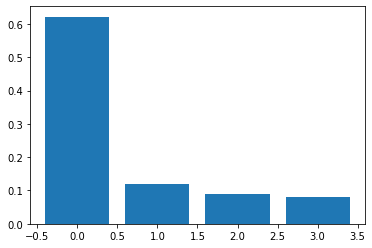

In [48]:
ln,cols = FeatAR.shape
for i in range(1,cols+1,1):
    pca = PCA(n_components=i)
    X2 = pca.fit_transform(FeatAR)
    exp_var_arr = pca.explained_variance_ratio_
    exp_var = sum(exp_var_arr)
    if exp_var>=0.9:
        break
    else:
        continue
print(f'Numero de Componentes que garante 90% da variancia explica é de {i}. Total Variância explicada de {round(exp_var*100,2)}%')
ass